In [1]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN

from matplotlib import pyplot as plt
import numpy as np

In [2]:
class VRLoss(nn.Module):

    def __init__(self, w_cos1 = 1., w_cos2 = 1., w_l2 = 2.) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.l2 = nn.MSELoss()
        s = w_cos1 + w_cos2 + w_l2
        self.w_cos1, self.w_cos2, self.w_l2 = w_cos1/s, w_cos2/s, w_l2/s

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = -self.cosinesim1(output, target)
        sim2 = -self.cosinesim2(output, target)
        l2 = self.l2(output, target)

        l = self.w_cos1*(sim1.exp().mean()-1e-1) + self.w_cos2*(sim2.exp().mean()-1e-1) + self.w_l2*l2
        
        return l

In [3]:
dataset = EncoderDecoderStaticDataset('/home/shivam/DKLabs/OilGasProject/WellLogCorrelation/data')
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True, num_workers = 4)
data_len = len(dataloader)
log_n = int(data_len//2)

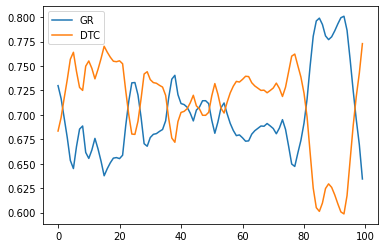

In [4]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = EncoderDecoder1DCNN(2, 50, activation=nn.PReLU)
model.to(device)
#model.load_state_dict(torch.load('./modelstate_vr_loss_l2_dominated'))
model.train()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): PReLU(num_parameters=1)
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,), bias=False)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PReLU(num_parameters=1)
    (5): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (6): PReLU(num_parameters=1)
    (7): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,), bias=False)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (11): PReLU(num_parameters=1)
    (12): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): PReLU(num_parameters=1)
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), s

In [7]:
criterion =  VRLoss() # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [8]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [9]:
rll = []
total_loss = []

In [10]:
model.train()
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 1,Running loss : 0.9374033808708191
Epoch : 0, Iteration : 3,Running loss : 0.738361120223999
Total loss : 0.6489518722709344
Epoch : 1, Iteration : 1,Running loss : 0.6263843476772308
Epoch : 1, Iteration : 3,Running loss : 0.5220836699008942
Total loss : 0.47859573242615683
Epoch : 2, Iteration : 1,Running loss : 0.46416059136390686
Epoch : 2, Iteration : 3,Running loss : 0.4112754315137863
Total loss : 0.39073075445330874
Epoch : 3, Iteration : 1,Running loss : 0.36883771419525146
Epoch : 3, Iteration : 3,Running loss : 0.34173521399497986
Total loss : 0.3209047378325949
Epoch : 4, Iteration : 1,Running loss : 0.3248091787099838
Epoch : 4, Iteration : 3,Running loss : 0.28858642280101776
Total loss : 0.28875958432956617
Epoch : 5, Iteration : 1,Running loss : 0.2791465222835541
Epoch : 5, Iteration : 3,Running loss : 0.24172990769147873
Total loss : 0.24466274131317528
Epoch : 6, Iteration : 1,Running loss : 0.23392458260059357
Epoch : 6, Iteration : 3,Running

Total loss : 0.14182940277518058
Epoch : 54, Iteration : 1,Running loss : 0.13837923854589462
Epoch : 54, Iteration : 3,Running loss : 0.14177385717630386
Total loss : 0.14085779658385686
Epoch : 55, Iteration : 1,Running loss : 0.14272016286849976
Epoch : 55, Iteration : 3,Running loss : 0.13949890434741974
Total loss : 0.1425004415974325
Epoch : 56, Iteration : 1,Running loss : 0.14259906113147736
Epoch : 56, Iteration : 3,Running loss : 0.1369401440024376
Total loss : 0.14457736726926299
Epoch : 57, Iteration : 1,Running loss : 0.1446705386042595
Epoch : 57, Iteration : 3,Running loss : 0.14014822244644165
Total loss : 0.14260208789183168
Epoch : 58, Iteration : 1,Running loss : 0.14435163140296936
Epoch : 58, Iteration : 3,Running loss : 0.13837682455778122
Total loss : 0.14026383356172212
Epoch : 59, Iteration : 1,Running loss : 0.1409725323319435
Epoch : 59, Iteration : 3,Running loss : 0.13797111809253693
Total loss : 0.14094869001787536
Epoch : 60, Iteration : 1,Running loss : 

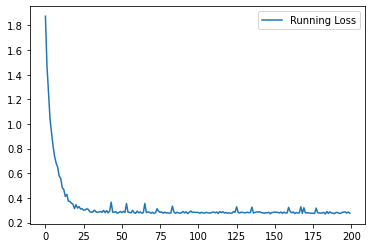

In [11]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

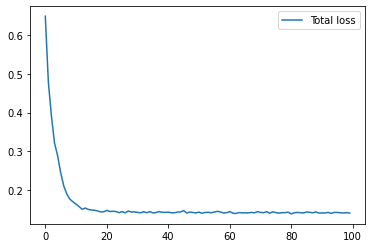

In [12]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [13]:
torch.save(model.state_dict(), './modelstate_vr_loss_l2_dominated_modified_network_run3_b32')

In [14]:
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): PReLU(num_parameters=1)
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,), bias=False)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PReLU(num_parameters=1)
    (5): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (6): PReLU(num_parameters=1)
    (7): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,), bias=False)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (11): PReLU(num_parameters=1)
    (12): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): PReLU(num_parameters=1)
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), s

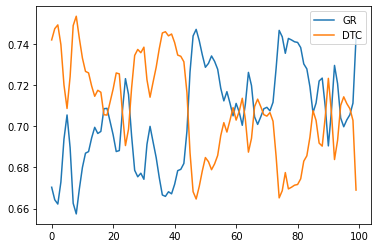

In [21]:
sample_data = dataset.__getitem__(10)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [22]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(sample_data_)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

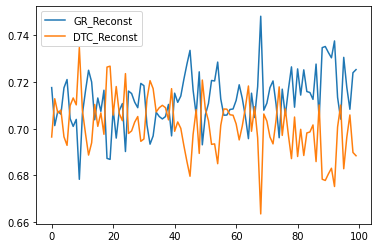

In [23]:
plt.plot(reconst_data[0, :], label='GR_Reconst')
plt.plot(reconst_data[1, :], label='DTC_Reconst')
plt.legend()
plt.show()